# Dynamic Containment

In this notebook, we use the simulations developed in the `modelling_frequency_data` notebook to investigate the state-of-charge of batteries offering three service powers: 2 MW, 5 WM, and 10 MW.

We look at how the state-of-charge responds to changes in frequency over time. We also investigate the optimal initial charges for each service. We use the simulations to investigate the uncertainties associated with how long it takes the battery charge to reach either zero or maximum capacity.

In [1]:
# Here we 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from dynamic_containment import utils

plt.rcParams['text.usetex'] = False

The goal in this notebook is to investigate how dynamic containment can be used to complement a power grid when frequency deviates from 50 Hz in the grid.

As a starting piont, assming only random Gaussian noise, and following the discussion in the `modelling_frequency_data` notebook, we can calculate the expected rate of change of the charge for all three service powers.

First, we set our parameters

In [2]:
service_powers = np.array([2, 5, 10])

max_cap = 4 # MWh

max_charge_rate = 4.0 # MW
max_discharge_rate = 5.0 # MW

max_percent = max_charge_rate / service_powers
min_percent = max_discharge_rate / service_powers

alpha = (1 - 0.05)/(0.5 - 0.2) # This is the slope of the response curve between the elbow and full response
ccharge = 1 - 0.5 * alpha # This is the constant for the curve in the discharge state
    
delta_freq_max = (max_percent - ccharge) / alpha
delta_freq_min = -(min_percent - ccharge) / alpha

To calculate the level of white noise, we can use the data for our variance. Note, we are using the original data to cteate our simulations. In this notebook we do not cut the data, since missing data does not impact the covariance, but cutting and moving data around will likely affect it.

In [3]:
freq_table = utils.read_and_clean()

## The expectation value of the charge

We showed in the `modelling_frequency_data` notebook that the mean value of the frequency in our test data is consistent with 50 Hz.

We also demonstrated that assuming only only Gaussian noise does a good job when predicting the expectation value of the charge of the battery when we ignore the limits of maximum capacity and an empty battery. We start with these assumptions, since Gaussian noise requires only an estimate of the variance, and so is less impacted by uncertainty. The expected charge at time $t$ is then given by the recursive relation

\begin{equation}
\left<C_t\right>=C_{t-1}+\Delta t\int^{\infty}_{-\infty} P_{\delta f}\left(\delta f\right|\sigma_{\delta f}^2)y(\delta f)\,\mathrm{d}\delta f
\end{equation}

where $\delta f=f-50$ Hz and $P_{\delta f}$ is a Normal distribution, with zero mean and variance $\sigma_{\delta f}^2$. $y(\delta f)$ is the peicewise linear function describing the response of the battery charge to $\delta f$, where we include the battery specifications. The charge at $t=0$, $C_0$ is the initial charge of the battery.

Here, we have made the assumption that $\delta f$ is unbound. Let's look at the validity this assumption


In [4]:
print(f"For the uncut data, the standard deviation of the frequency is {np.round(freq_table.delta_freq.std(), 3)} Hz")

For the uncut data, the standard deviation of the frequency is 0.06 Hz


In [5]:
print("Respectively for the 2 MW, 5 MW and 10 MW service powers\n")
print("\tThe maximum charge rates are at %s percent, %s percent, and %s percent" % tuple(100*max_percent))
print(f"\tThese are when delta freq are {np.round(delta_freq_max, 2)} Hz\n")
print(f"\tThe maximum discharge rates are at %s percent, %s percent, and %s percent" % tuple(100*min_percent))
print(f"\tThese are when delta freq are {np.round(delta_freq_min, 2)} Hz")

Respectively for the 2 MW, 5 MW and 10 MW service powers

	The maximum charge rates are at 200.0 percent, 80.0 percent, and 40.0 percent
	These are when delta freq are [0.82 0.44 0.31] Hz

	The maximum discharge rates are at 250.0 percent, 100.0 percent, and 50.0 percent
	These are when delta freq are [-0.97 -0.5  -0.34] Hz


In [6]:
print(f"For the 10 MW case, where the maximum and minimum charge rates are at the lowest frequencies, we expect these charge rates to be exceeded, on average, for 1 second every {np.round((1.0/(1.0 - utils.probability_tails(0.31/0.06, 0.34/0.06)))/86400, 2)} days") 

For the 10 MW case, where the maximum and minimum charge rates are at the lowest frequencies, we expect these charge rates to be exceeded, on average, for 1 second every 91.54 days


The fact that some of the charge and discharge rates are greater than 100 % is an indication that the maximum charge and discharge rates are greater than the service power, and so these should be capped at 100 %.

For those cases where the rates are lower than 100%, these battery specifications cannot achieve the contract requirements, and these batteries should not be used. For the 5 MW case, where the maximum discharge rate is 100%, but the charge rate is 80%, this can fill the contract of a `low` flavour. The 10 MW case cannot fulfill the requirements of any service contract.

It is clear the magnitude of the minimum and maximum values of the frequencies in all cases is > 5 $\sigma_{\delta f}$, and so, when calculating the expectation of the rate of change in charge, it is reasonable to assume that the integral is unbound. However, it should be noted that, given the length of time that the battery runs, these frequencies may occur. Assuming normal distributed noise-only, the integral above gives us the rate of change of charge

\begin{equation}
\frac{\mathrm{d}C}{\mathrm{d}t}=\int^{\infty}_{-\infty} P_{\delta f}\left(\delta f\right|\sigma_{\delta f}^2)y(\delta f)\,\mathrm{d}\delta f
\end{equation}

In [7]:
# This calculates the above integral

dcdt = np.array([
    utils.calc_gaussian_slope(freq_table.delta_freq.std(), sp)
    for sp in service_powers
])

This provides our estimate of the rate of change of charge when we are not impacted by specifications for the 2 MW, 5 MW and 10 MW services respectively as

In [8]:
print(f"The average rate of change of charges: {dcdt} MW")

The average rate of change of charges: [-3.23914437e-07 -8.09786093e-07 -1.61958050e-06] MW


Assuming we start with a full battery, the expectation of the charge is then

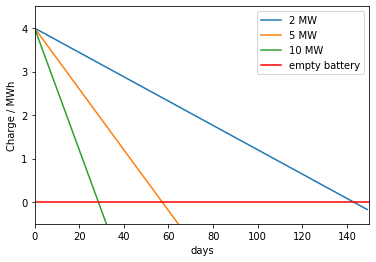

In [9]:
days = np.arange(150)
plt.plot(days, max_cap + days * (dcdt[0]*(3600.0 * 24.0)), label="2 MW")
plt.plot(days, max_cap + days * (dcdt[1]*(3600.0 * 24.0)), label="5 MW")
plt.plot(days, max_cap + days * (dcdt[2]*(3600.0 * 24.0)), label="10 MW")
plt.axhline(0, color='red', label="empty battery")
plt.ylabel("Charge / MWh")
plt.xlabel("days")
plt.xlim([0, 150])
plt.ylim([-0.5, max_cap + 0.5])
plt.legend()


## Incuding stochasticity

Now we follow the more realistic approach and generate a suite of simulations using the two-point correlation of the frequency data, which capatures temporal correlations.

We start by calculating the covariance of $\delta f$ as a function of temporal separation

In [10]:
# Here, we calculate the covariance of the data as a function of temporal separation
real_space_cov = utils.temporal_covariance(freq_table, max_sep=10801, step=60)

  0%|          | 0/181 [00:00<?, ?it/s]

Next, we set the number of realisations and the time step to sample data at. We are currently using a fairly large time step to speed things up, but we verified that sampling at this scale should not cause significant increases in the uncertainty estimates due to the level of correlation at smaller scales.

In [11]:
# This is the number of realisations.
nreals = 200
# We sample the time (this may affect the noise properties)
time_step = 300

Now we create independent simulations for the three service powers. These simulate how the charge of the batteries changes over time, without considering the capacity of the battery. These will then be used to see where the different realisations hit capacity or reach zero. 

Note, we output results for the `high`, `low` and `both` scenarios.

In [12]:
summaries, reals = utils.simulations_for_anaylsis(
    real_space_cov,
    service_powers,
    nreals,
    time_step,
    num_days=400,
    block_length=10800,
    max_discharge_rate=5,
    max_charge_rate=4,
    charge_efficiency=0.9
)

creating simulation for service power 2
creating simulation for service power 5
creating simulation for service power 10


We can select a date to look at the distribution of charges over the realisations. 

In [13]:
day = 10 # We will look at the start of day 10
sp = 2 # the service power to look at

keep_charge = int(day*86400/time_step)
samp_charge = []

for s in reals[sp]:
    
    samp_charge.append(float(reals[sp][s].iloc[keep_charge].culm_charge))

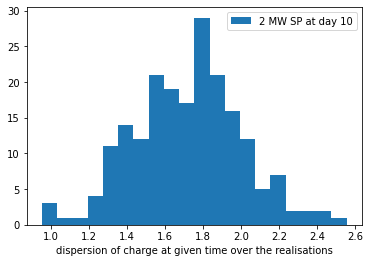

In [14]:
hist = plt.hist(0.5*max_cap + np.array(samp_charge), bins=20, label=f"{sp} MW SP at day {day}")
plt.xlabel("dispersion of charge at given time over the realisations")
plt.legend()

We will now find the intial charge that provides the longest expected time before fully charging or running out of charge

In [15]:
service_power = 10
num_charge_steps = 81
min_charge_lim = 2 # This is the lower bound of the optimisation
max_charge_lim = 4 # This is the upper bound of the optimisation

In [16]:
E_best, d_mean, E_arr = utils.find_E0_for_max_time(
    reals,
    service_power,
    max_cap=max_cap,
    min_charge_lim=min_charge_lim,
    max_charge_lim=max_charge_lim,
    num_charge_steps=num_charge_steps,
    poly_deg=8
)

This is a simple optimsation that uses polyfit to fit a curve to the mean termination date as a function of the intial charge, as shown below

In [17]:
res = np.polyfit(E_arr, d_mean, deg=8)

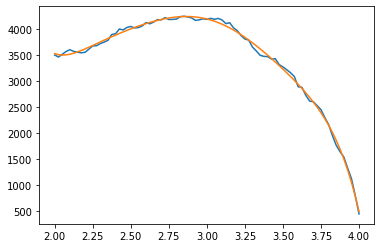

In [18]:
plt.plot(E_arr, d_mean)
plt.plot(E_arr, np.poly1d(res)(E_arr))

The best starting point is then

In [19]:
print(f"C_0 = {E_best[0]} MWh")

C_0 = 2.875 MWh


This gives the expected best date

In [20]:
dates = utils.max_date_func(E_best, reals, service_power, max_cap)*time_step /(3600.0 * 24.0)

print(f"{np.round(np.mean(dates), 2)} days")

14.71 days


Let's look at a histogram of the termination dates over the realisations

Text(0, 0.5, 'N')

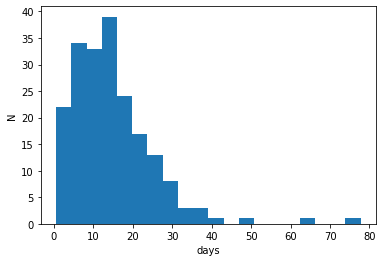

In [21]:
hist = plt.hist(dates, bins=20)
plt.xlabel("days")
plt.ylabel("N")

From this, we can see that there is a large dispersion in the simulations.

Lets run this for all three service powers and look at the 95% confidence intervals, running with the three flavours - `both`, `high` and `low`

In [22]:
results_both = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_charge_lim=min_charge_lim,
    max_charge_lim=max_charge_lim,
    num_charge_steps=num_charge_steps,
    poly_deg=8,
    verbose=False,
)

In [23]:
results_low = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_charge_lim=min_charge_lim,
    max_charge_lim=max_charge_lim,
    num_charge_steps=num_charge_steps,
    service='low',
    verbose=False
)

In [24]:
results_high = utils.service_power_loop(
    reals,
    service_powers,
    max_cap=max_cap,
    time_step=time_step,
    min_charge_lim=min_charge_lim,
    max_charge_lim=max_charge_lim,
    num_charge_steps=num_charge_steps,
    service='high',
    verbose=False
)

In [25]:
pd.concat([results_both["table"], results_high["table"], results_low["table"]])

,Initial Charge,Expected Termination Date,95.0% Confidence Interval
2MW - both,3.475,120.4 days,51.38 - 197.42 days
5MW - both,3.175,40.38 days,2.07 - 95.2 days
10MW - both,2.875,14.71 days,1.44 - 38.18 days
2MW - high,0.000,15.9 days,14.56 - 17.63 days
5MW - high,0.000,6.36 days,5.44 - 7.4 days
10MW - high,0.000,3.2 days,2.54 - 3.78 days
2MW - low,4.000,14.32 days,12.86 - 15.77 days
5MW - low,4.000,5.75 days,4.87 - 6.82 days
10MW - low,4.000,2.87 days,2.33 - 3.53 days


We have already stated that the 10MW service cannot be achieved given the batter specifications. Also, the battery can only provide the `low` flavour due to the limitation of the maximum charge rate.

We also see that the confidence interval is very large 

In [26]:
max_cap_arr = np.linspace(2, 20, num=10)

results = utils.loop_max_cap(
    reals,
    max_cap_arr,
    service_power,
    time_step,
    num_charge_steps,
    service="both",
    poly_deg=8
)

In [27]:
plt.plot(max_cap_arr, exp_dates)
plt.plot(max_cap_arr, lower_limits)
plt.plot(max_cap_arr, upper_limits)

NameError: name 'exp_dates' is not defined

In [ ]:
plt.plot(max_cap_arr, exp_dates)
plt.plot(max_cap_arr, np.array(upperlower_limits)
plt.plot(max_cap_arr, upper_limits)